In [9]:
from os import path
from utils import fix_path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels import robust
from statsmodels.stats.stattools import medcouple
import json

def fx_unsupervised(v_uk_id):
	#v_uk_id= 123456
	my_path =  'db/data/' + v_uk_id + "/"
	v_input_json_file = my_path + "details.json"
	v_output_json_file = my_path + "result_desc.json"
	v_output_result_csv = my_path+"result_individual_columns.csv"
	v_output_result_csv = my_path+"result.csv"
	with open(v_input_json_file, encoding="utf-8") as data_file:
		input_json = json.load(data_file)

	v_input_csv = input_json['filename']

	df = pd.read_csv(v_input_csv)
	df['anomalydetectid']=df.index
	######################
	v_id = 'anomalydetectid'
	v_analysis_columns_list = input_json['dimension']
	df_outliers = pd.DataFrame({})
	#v_analysis_columns = ''.join(v_analysis_columns_list)
	for my_analysis_column in v_analysis_columns_list:
		v_df_temp = fx_ThreeSigmaRule(df[v_id], df[my_analysis_column], 2, 1)
		v_df_temp['Outlier Type'] = 'Three Sigma Rule'
		v_df_temp['Analysis Column'] = my_analysis_column
		df_outliers = pd.concat([df_outliers, v_df_temp])
	######################
	df_outliers_out = pd.merge(df_outliers, df, on='anomalydetectid')
	df_outliers_out.to_csv(v_output_result_csv, encoding="utf-8", index=False, header=True)

	x_groupby_type = df_outliers.groupby(['Analysis Column'])
	df2 = x_groupby_type.count()
	df2.reset_index(inplace=True)
	df3 = df2.sort_values(['data'], ascending=True).head(4)
	df3.reset_index(inplace=True)

	for i, r in df3.iterrows():
		v_filename = 'image'+str(i)
		v_list = df.loc[:, [r['Analysis Column']]]
		v_title = 'Outliers for '+r['Analysis Column']
		v_column=r['Analysis Column']
		#fx_box_plot (v_uk_id,v_list , v_title,v_filename )
		#plt.scatter(df['anomalydetectid'].values,df[v_column].values)
		fx_scatter_plot(v_uk_id,df['anomalydetectid'].values,df[v_column].values, v_title,v_filename)

	##################################json code 
	v_output_json_contents = {
			"image_title1": "nish1",
			"image_title2": "jfbgcjshhgsj",
			"image_title3": "jfbgcjshhgsj",
			"image_title4": "jfbgcjshhgsj",
			"image_name1": "image1.png",
			"image_name2": "image2.png",
			"image_name3": "image3.png",
			"image_name4": "image4.png",
			"image_desc1": "jfbgcjshhgsj",
			"image_desc2": "jfbgcjshhgsj",
			"image_desc3": "jfbgcjshhgsj",
			"image_desc4": "jfbgcjshhgsj",
			"model": [{"model_desc": "ssss", "model_file": "ssss"}, {"model_desc": "ssss", "model_file": "ssss"}]
		}
		

	with open(v_output_json_file, 'w') as outfile:
		json.dump(v_output_json_contents, outfile)
	##################################    

	return df_outliers_out
	
	


def fx_scatter_plot (v_uk_id , v_id_series,v_column_series , v_title,v_filename ):
    my_path = "db/data/" + v_uk_id + "/"
    fig, ax = plt.subplots()
    #jpg_filename = my_path + v_filename+'.jpg'
    png_filename = my_path + v_filename
    ax.scatter(v_id_series,v_column_series)
    ax.set_title(v_title)
    fig.tight_layout()
    #fig.show()
    #fig.savefig(jpg_filename, dpi=1000)
    fig.savefig(png_filename+'.png', dpi=1000)
	
	
	
def fx_box_plot (v_uk_id,v_list , v_title,v_filename ):
    my_path = "db/data/" + v_uk_id + "/"
    fig, ax = plt.subplots()
    jpg_filename = my_path + v_filename+'.jpg'
    png_filename = my_path + v_filename+'.png'
    x = range(len(v_list))
    ax.boxplot(v_list, patch_artist=True)
    ax.set_title(v_title)
    fig.tight_layout()
    #fig.show()
    fig.savefig(jpg_filename, dpi=1000)
    fig.savefig(png_filename+'.png', dpi=1000)
	
def fx_ThreeSigmaRule(series_id, series_data, v_number_of_std, v_masking_Iteration):
	'''
	value should be in +- range of -->mean + n * std
	Probability
	n =1 --> 68
	n =2 -->  95
	n= 3  --> 99.7
	Usage : 
	df_outliers= fx_ThreeSigmaRule(df['myid'],df['series1'], 2,2)
	df_outliers
	Good for normal distributed data ---series or sequences
	Drawback :
	Not good when data is not normal distribution 
	Sensitive to extreme points  ---Masking effect. If extreme value is too large then it overshadow other values
	-->iteration solves this issue
	'''

	v_df = pd.DataFrame({})
	v_df_outliers_final = pd.DataFrame({})
	v_df['anomalydetectid'] = series_id
	v_df['data'] = series_data

	v_Iteration = 0

	while (v_Iteration < v_masking_Iteration):
		#############################
		print(str(v_masking_Iteration))
		v_masking_Iteration = v_masking_Iteration - 1
		v_threshold = np.std(v_df['data']) * v_number_of_std
		v_mean = np.mean(v_df['data'])
		print(str(v_mean - v_threshold))
		print(str(v_threshold + v_mean))
		where_tuple = (np.abs(v_df['data'] - v_mean) > v_threshold)
		v_df_outliers = v_df[where_tuple]

		# v_outliersList = [ [r[0] , r[1]] for  i,r in v_df.iterrows() if np.abs(r[1]) > v_threshold + v_mean]

		if (len(v_df_outliers) > 0):

			v_df_outliers_final = pd.concat([v_df_outliers_final, v_df_outliers])

			# Update data - remove otliers from the list
			# list1 = [x for x in list1 if x not in v_outliersList[1]]
			where_tuple = (np.abs(v_df['data'] - v_mean) <= v_threshold)
			v_df = v_df[where_tuple]

		else:

			break

		############################

	if len(v_df_outliers_final) > 0:

		return (v_df_outliers_final)

	else:
		return (pd.DataFrame({}))
		print("Three are No Outliers")


###############################################################################
def fx_mad_Rule(series_id, series_data, v_number_of_std):
    '''
    value should be in +- range of -->median + n * MAD/.6745
    Usage : 
    df_outliers= fx_mad_Rule(df['myid'],df['series1'], 2)
    df_outliers
    Good for not normal distributed data
    No issue with extreme points
    Drawback :
    Not good when data is normal distribution 
    Too agressive

    '''
    # warning ignore for verylarge values 
    # np.seterr(invalid='ignore')
    # np.errstate(invalid='ignore')
    # np.warnings.filterwarnings('ignore')
    v_df = pd.DataFrame({})
    v_df_outliers_final = pd.DataFrame({})
    v_df['id'] = series_id
    v_df['data'] = series_data

    #############################
    v_threshold = robust.mad(v_df['data'], c=1) * v_number_of_std / 0.6745
    v_median = np.median(v_df['data'])

    print(str(v_median - v_threshold))
    print(str(v_threshold + v_median))
    where_tuple = (np.abs(v_df['data'] - v_median) > v_threshold)
    v_df_outliers_final = v_df[where_tuple]

    ############################

    if len(v_df_outliers_final) > 0:

        return (v_df_outliers_final)

    else:
        print("Three are No Outliers")


###############################################################################
def fx_boxplot_Rule(series_id, series_data):
    '''
    value should be in +- range of -->(y > q3 + 1.5 * iqr) or (y < q1 - 1.5 * iqr
    Usage : 
    df_outliers= fx_boxplot_Rule(df['myid'],df['series1'])
    df_outliers
    For presense of outliers --less sensitive than 3 sigma but more sensitive to MAD test 
    No depenedence of median and mean
    better for moderately asymmetric distribution
    Drawback :
    Too agressive

    '''
    # warning ignore for verylarge values 
    # np.seterr(invalid='ignore')
    # np.errstate(invalid='ignore')
    # np.warnings.filterwarnings('ignore')
    v_df = pd.DataFrame({})
    v_df_outliers_final = pd.DataFrame({})
    v_df['id'] = series_id
    v_df['data'] = series_data

    #############################
    q1 = np.percentile(v_df['data'], 25)

    q3 = np.percentile(v_df['data'], 75)

    iqr = q3 - q1

    print(str(q1 - 1.5 * iqr))
    print(str(q3 + 1.5 * iqr))
    where_tuple1 = (v_df['data'] > q3 + 1.5 * iqr)
    where_tuple2 = (v_df['data'] < q1 - 1.5 * iqr)
    v_df_outliers_final = v_df[where_tuple1 | where_tuple2]

    ############################

    if len(v_df_outliers_final) > 0:

        return (v_df_outliers_final)

    else:
        print("Three are No Outliers")


###############################################################################

def fx_adjusted_boxplot_Rule(series_id, series_data):
    '''
    value should be in +- range of -->(y > q3 + 1.5 * iqr) or (y < q1 - 1.5 * iqr
    Usage : 
    df_outliers= fx_boxplot_Rule(df['myid'],df['series1'])
    df_outliers
    For presense of outliers --less sensitive than 3 sigma but more sensitive to MAD test 
    No depenedence of median and mean
    better for moderately asymmetric distribution
    Drawback :
    Too agressive

    '''
    # warning ignore for verylarge values 
    # np.seterr(invalid='ignore')
    # np.errstate(invalid='ignore')
    # np.warnings.filterwarnings('ignore')
    v_df = pd.DataFrame({})
    v_df_outliers_final = pd.DataFrame({})
    v_df['id'] = series_id
    v_df['data'] = series_data

    #############################
    q1 = np.percentile(v_df['data'], 25)

    q3 = np.percentile(v_df['data'], 75)

    iqr = q3 - q1

    mc = medcouple(v_df['data'])

    if (mc >= 0):

        lr = q1 - 1.5 * iqr * np.exp(-4 * mc)
        ur = q3 + 1.5 * iqr * np.exp(3 * mc)
    else:
        lr = q1 - 1.5 * iqr * np.exp(-3 * mc)
        ur = q3 + 1.5 * iqr * np.exp(4 * mc)

    print(str(lr))
    print(str(ur))

    where_tuple1 = (v_df['data'] > ur)
    where_tuple2 = (v_df['data'] < lr)
    v_df_outliers_final = v_df[where_tuple1 | where_tuple2]

    ############################

    if len(v_df_outliers_final) > 0:

        return (v_df_outliers_final)

    else:
        print("Three are No Outliers")

###############################################################################


###############################################################################


###############################################################################


###############################################################################


###############################################################################


1
-162.26559591728437
189789.9847460786
1
-3.91738473043482
3.917384730434828
1
-3.302611360957308
3.3026113609573087
1
-3.032504686552633
3.032504686552615
1
-2.831732178551021
2.8317321785510265
1
-2.760488621805779
2.7604886218057763
1
-2.664537501707848
2.6645375017078523
1
-2.474182852740748
2.4741828527407446
1
-2.388701611782942
2.388701611782942
1
-2.19726032098358
2.197260320983574
1
-2.177695707687199
2.1776957076872026
1
-2.041422471543762
2.041422471543764
1
-1.998399270711585
1.9983992707115814
1
-1.990544965690458
1.9905449656904615
1
-1.9171878567385308
1.9171878567385339
1
-1.8306288094065353
1.8306288094065424
1
-1.7525026981190222
1.7525026981190248
1
-1.6986711451966034
1.6986711451966021
1
-1.6763494760929802
1.6763494760929811
1
-1.6280781433166125
1.6280781433166143
1
-1.541847342938716
1.541847342938717
1
-1.4690454497166046
1.469045449716605
1
-1.451400572832812
1.4514005728328139
1
-1.2489183986145043
1.2489183986145052
1
-1.2112920091349433
1.2112920091349522


,Analysis Column,Outlier Type,anomalydetectid,data,Time,V1,V2,V3,V4,V5,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,V1,Three Sigma Rule,18,-5.401258,14.0,-5.401258,-5.450148,1.186305,1.736239,3.049106,...,-0.503600,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,0
1,V2,Three Sigma Rule,18,-5.450148,14.0,-5.401258,-5.450148,1.186305,1.736239,3.049106,...,-0.503600,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,0
2,V5,Three Sigma Rule,18,3.049106,14.0,-5.401258,-5.450148,1.186305,1.736239,3.049106,...,-0.503600,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,0
3,V20,Three Sigma Rule,18,-2.196848,14.0,-5.401258,-5.450148,1.186305,1.736239,3.049106,...,-0.503600,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,0
4,V23,Three Sigma Rule,18,2.458589,14.0,-5.401258,-5.450148,1.186305,1.736239,3.049106,...,-0.503600,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,0
5,V28,Three Sigma Rule,18,0.949594,14.0,-5.401258,-5.450148,1.186305,1.736239,3.049106,...,-0.503600,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,0
6,V1,Three Sigma Rule,85,-4.575093,55.0,-4.575093,-4.429184,3.402585,0.903915,3.002224,...,-0.047365,0.853360,-0.971600,-0.114862,0.408300,-0.304576,0.547785,-0.456297,200.01,0
7,V2,Three Sigma Rule,85,-4.429184,55.0,-4.575093,-4.429184,3.402585,0.903915,3.002224,...,-0.047365,0.853360,-0.971600,-0.114862,0.408300,-0.304576,0.547785,-0.456297,200.01,0
8,V3,Three Sigma Rule,85,3.402585,55.0,-4.575093,-4.429184,3.402585,0.903915,3.002224,...,-0.047365,0.853360,-0.971600,-0.114862,0.408300,-0.304576,0.547785,-0.456297,200.01,0
9,V5,Three Sigma Rule,85,3.002224,55.0,-4.575093,-4.429184,3.402585,0.903915,3.002224,...,-0.047365,0.853360,-0.971600,-0.114862,0.408300,-0.304576,0.547785,-0.456297,200.01,0


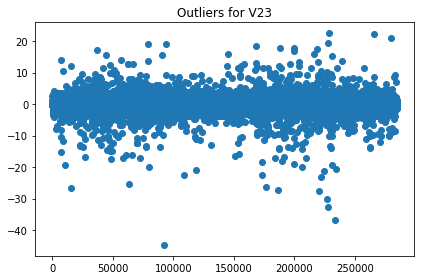

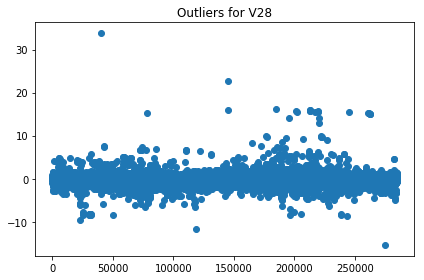

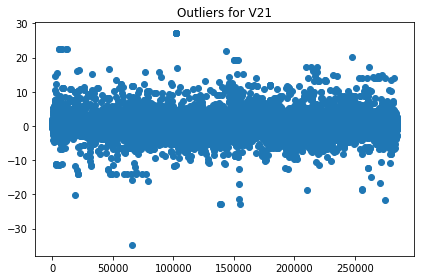

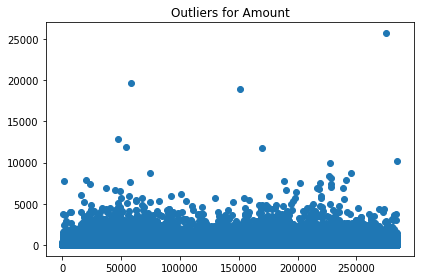

In [10]:
fx_unsupervised('123456')